In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# Import ionosphere dataset
# 351 instances, 34 attributes, binary class labels
data = pd.read_csv('ionosphere_processed.csv', index_col=0)
data_mat = data.values
n_rows, n_cols = data_mat.shape
X = data_mat[:, :n_cols-1]

# Declare autoencoder training and test sets
# 300 training, 51 test
X_train = X[:300]
X_test = X[300:]

# Add Gaussian noise to training and test sets
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, -1., 1.)
X_test_noisy = np.clip(X_test_noisy, -1., 1.)

/Users/alexbenasutti/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Autoencoder Layer Dimensions
input_dim    = 34
encoding_dim = 5
output_dim = input_dim

'''
De-noising Autoencoder
'''

# Input
inputs = Input(shape=(input_dim,))

# Encoder/Hidden Layer
encoded = Dense(encoding_dim, activation='relu')(inputs)

# Decoder/Output
decoded = Dense(output_dim, activation='sigmoid')(encoded)

# Autoencoder Model with Gaussian noise added to data
autoencoder_noise = Model(inputs, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Encoder Model
encoder = Model(inputs, encoded)

In [4]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder_noise.layers[-1]

# Decoder Model using encoder outputs as input and decoder layer as output
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
# Compile model
autoencoder_noise.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
# Fit autoencoder with noisy training data
history_noise = autoencoder_noise.fit(X_train_noisy, X_train_noisy,
                                epochs=50,
                                batch_size=25,
                                shuffle=True,
                                verbose=0,
                                validation_data=(X_test_noisy, X_test_noisy))

Instructions for updating:
Use tf.cast instead.


In [7]:
# Encode and decode some noisy test data
encoded_imgs = encoder.predict(X_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

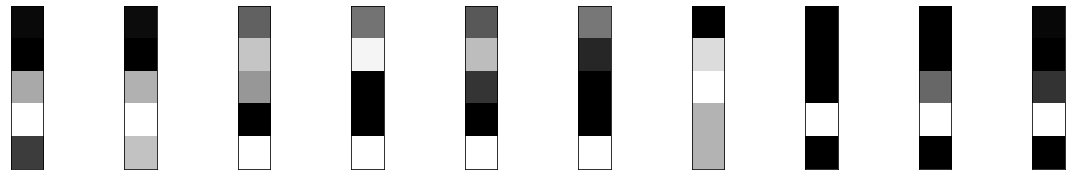

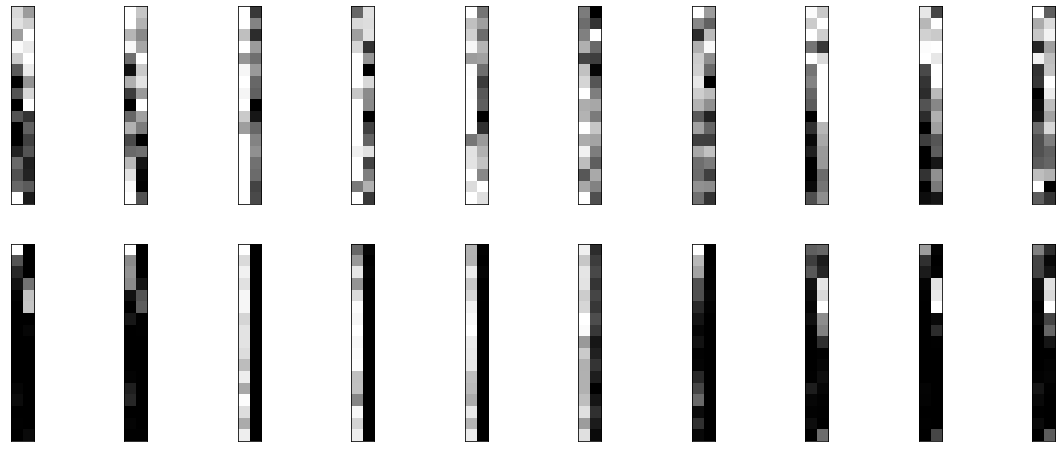

In [8]:
# n Encoded Images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(1, 5).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# n Decoded Images
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original Noisy Test Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(17, 2).astype(float))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction of Test Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(17, 2).astype(float))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

dict_keys(['val_loss', 'loss'])


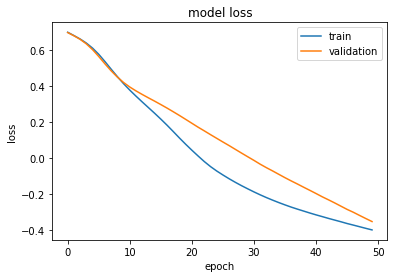

In [9]:
# Plot loss
print(history_noise.history.keys())

plt.plot(history_noise.history['loss'])
plt.plot(history_noise.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [11]:
'''
Sparse Autoencoder: 
L2-Regularization
'''

# Input
inputs = Input(shape=(input_dim,))

# Encoder/Hidden Layer
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l2(10e-5))(inputs)

# Decoder/Output
decoded = Dense(output_dim, activation='sigmoid')(encoded)

# Autoencoder Model with L2-Regularization
autoencoder_l2 = Model(inputs, decoded)


# Encoder Model
encoder = Model(inputs, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder_l2.layers[-1]

# Decoder Model using encoder outputs as input and decoder layer as output
decoder = Model(encoded_input, decoder_layer(encoded_input))


# Compile Model
autoencoder_l2.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
# Fit autoencoder with regular training data
history_l2 = autoencoder_l2.fit(X_train, X_train,
                epochs=50,
                batch_size=25,
                shuffle=True,
                verbose=0,
                validation_data=(X_test, X_test))

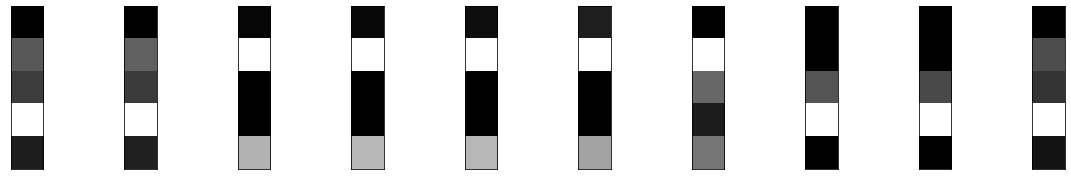

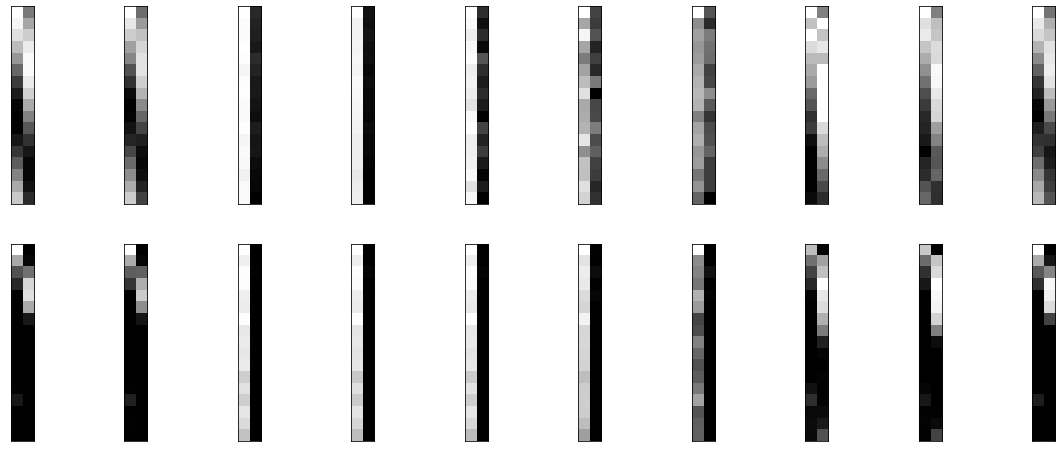

In [13]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

# n Encoded Images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(1, 5).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# n Decoded Images
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original Noisy Test Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(17, 2).astype(float))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction of Test Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(17, 2).astype(float))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

dict_keys(['val_loss', 'loss'])


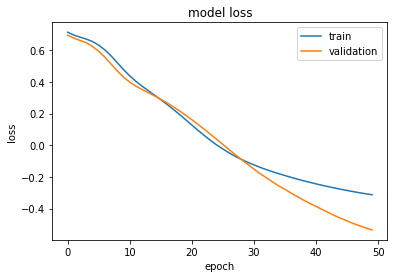

In [14]:
# Plot loss
print(history_l2.history.keys())

plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()